<div align='center'>
    
## 시간과 계절이 공유 차량 수요에 미치는 영향
</div>

In [1]:
! pip install pmdarima

- **pmdarima(Pyramid-arima)**는 R에서 실행되는 **auto.arima**를 파이선에서 실행시킬 수 있도록 설계된 통계 라이브러리이다.(시계열 분석에 유용하게 사용됨.)
- [pmdarima: ARIMA estimators for Python](http://alkaline-ml.com/pmdarima/)

: track01에서의 상관관계 분석이나 선형 회귀 분석을 통한 차량 수요 예측은 제대로 할 수 없었다. 그 이유는 상관관계 분석이나 선형 회귀 분석은 과거의 관측값에서 얻은 정보를 활용하지 못했기 때문이다.

차량 수요 예측의 경우, 과거의 수요를 분석함으로써 시간의 흐름에 따른 수요의 패턴을 파악하고, 이를 통해 미래의 수요를 예측하여 보다 정확한 예측을 할 수 있다.

이번에는 시계열 자료의 패턴을 이용한 ARIMA 모형으로 차량 수요 예측을 하고, ARIMA모형에 계절적 성분을 추가한 SARIMA를 이용하겠다.

### 1. 시계열 분석과 ARIMA(Auto-Regressive Integrated Moving Average) 모형

: ARIMA 모형 결정 과정을 간략히 하자면, 데이터에 계절성과 정상성이 잇는지 그래프와 검정을 통해 살펴보고, 만약 계절성과 정상성이 존재하면 차분과 로그 변환을 통해 계절성을 제거하여 정상적인 시계열 데이터로 만든다. 그 후 ARIMA 모형의 모수를 결정하여 모형을 적합한 뒤, 모형에 적절했는지 점검한다.

**라이브러리 불러오기**

In [2]:
import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

> **pmdarima**는 일정 버전 이상의 라이브러리가 먼저 설치되어 있어야 설치된다.
>> - numpy (>=1.17.3)
>> - scipy (>=1.3.2)
>> - scikit-learn (>=0.22)
>> - pandas (>=0.19)
>> - statsmodels (>=0.11)

In [3]:
print( f'# pandas:       {pd.__version__}' )
print( f'# numpy:        {np.__version__}' )
print( f'# matplotlib:   {mpl.__version__}' )  
print( f'# seaborn:      {sns.__version__}' )
print( f'# statsmodels:  {sm.__version__}' )
print( f'# scikit-learn: {sklearn.__version__}' )
print( f'# pmdarima:     {pm.__version__}' )

# pandas:       1.2.0
# numpy:        1.22.2
# matplotlib:   3.4.3
# seaborn:      0.11.1
# statsmodels:  0.12.1
# scikit-learn: 1.0
# pmdarima:     1.8.3


**데이터 준비**

In [4]:
file_path_raws = os.getenv('HOME') + '/aiffel/demand_forecasting/data/raws.csv'
df_raws = pd.read_csv(file_path_raws)

df_op_ts = df_raws.set_index('target_dates').sort_index()
df_op_ts.head()

,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,op_rate_1d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
target_dates,,,,,,,,,,,,,,,,,,,,,
2019-09-08,0.381038,0.134719,0.095673,0.081302,0.073248,0.067846,0.059269,0.050881,0.392379,0.130225,...,3850,1190,0,18.8,24.4,9,2019,36,6,True
2019-09-09,0.294693,0.094521,0.058669,0.049279,0.040270,0.033519,0.029069,0.024346,0.316189,0.095190,...,2392,1777,0,90.4,24.7,9,2019,37,0,False
2019-09-10,0.327382,0.115586,0.065420,0.050327,0.043757,0.035807,0.030258,0.026159,0.359647,0.119441,...,2827,2526,0,127.7,24.9,9,2019,37,1,False
2019-09-11,0.382523,0.149016,0.094511,0.073380,0.062836,0.055696,0.048563,0.043774,0.409784,0.142832,...,5867,5083,0,98.4,24.1,9,2019,37,2,False
2019-09-12,0.559916,0.266497,0.201238,0.166553,0.143653,0.130768,0.119568,0.106934,0.568754,0.241148,...,9692,9838,0,38.8,21.3,9,2019,37,3,False


**시계열 분석**

: 시게열 데이터는 주식 거래 데이터, 기후 데이터, 유가 변동 데이터 등과 같이 **시간 순서대로 발생한 데이터**이다. 다른 데이터와 달리 시계열 데이터는 시간과 연관되어 있기 때문에, 시계열 데이터를 제대로 분석하고, 예측하기 위해서는 일반적인 통계 기법을 사용하는 것보다 시계열 기법을 사용하는 것이 좋다. 시계열 분석과 일반적인 통계 분석은 차이가 있기 때문이다.

일반적인 통계 분석은 데이터가 독립적이고 동일하게 분포되어야 한다는 I.I.D(독립 항등 분포, Independent and Identically Distributed) 가정을 만족해야 한다. 반면 시계열 분석은 **약정상성(weak stationarity) 가정**을 만족해야 한다.

- **weak stationarity assumption**
    - 1) 시간(t)이 흘러도 평균이 같다.
    - 2) 시간(t)이 흘러도 분산이 같다.
    - 3) 자기공분산 또는 각 값들의 상관성(Auto-Correlation, 자기상관관계)이 시간이 아니라 시차에 의존한다.

: 각 가장에 대해 조금 더 살펴보자면, 우선 1번과 2번 과정의 경우, 평균과 분산이 시간(t)에 따라 변하면 예측이 어려워지기 때문에 평균과 분산이 시간이 흘러도 일정해야 한다.

예를 들어 12시일 때의 평균과 분산이 각각 10과 5, 13시일 때의 평균과 분산이 각각 200과 100, 14시일 때의 평균과 분산이 각각 3과 2, ... 이런 식으로 평균과 분산이 시간에 따라 계속 변하면 그 데이터는 예측이 불가능하다.

3번 가정인 자기공분산 또는 각 값들의 상관성이 시차에 의존한다는 의미는 t 시점과 t+s 시점의 공분산과 t 시점과 t-s 시점의 공분산이 같다라는 의미다.

만약 1월 1일과 1월 2일의 공분산과 1월 2일과 1월 3일의 공분산이 0.8이고, 1월 1일과 1월 3일의 공분산과 1월 2일과 1월 4일의 공분산이 0.4라면, 시차 1일 때 공분산은 0.8이고 시차 2일 때 공분산이 0.4라는 것을 추측할 수 있다. 따라서 12월 23일의 값이 주어졌을 때, 0.8의 공분산을 가지는 값을 12월 24일의 값, 0.4의 공분산을 가지는 값을 12월 25일의 값으로 예측할 수 있다.

> 공분산은 확률변수가 두 개 일때의 분산이다. 각 변수의 분포가 서로 얼마나 관련이 있는지를 수치적으로 표현한 것으로 해석할 수 있으며, 각 변수의 평균에서의 편차를 곱한 것의 평균이라고 정의한다.

- 분산(Variance, VAR(X))

$$ VAR(X) = \frac{1}{n-1}\sum_{i=1}^n (x_i - E(X))^2 $$

- 공분산(Covariance. COV(X, Y))

$$ COV(X, Y) = \frac{1}{n-1}\sum_{i=1}^n (x_i - E(X))(y_i - E(Y)) $$
$$ X, Y: 확률변수,  x_i,y_i: 관측값,  E(X),E(Y): 평균 $$

> 상관관계는 공분산을 분산으로 다시 나누어주어 공분산을 (-1,1) 범위로 스케일링 해준 것이라고 볼 수 있다.

- 상관관계

$$ COR(X, Y) = \frac{COV(X, Y)}{\sqrt{VAR(X)VAR(Y)}} $$

> 이때 시계열의 경우, xt와 xt+1의 상관관계를 계산하므로 COV(Xt, Xt+1), COR(Xt, Xt+1)를 각각 자기공분산, 자기상관관계라고 칭한다. 이는 ACF(Auto Correlation Function)와도 통하는 개념이다.

하지만 약정상성 가정을 만족하지 않는 비정상(non-stationary) 시계열 데이터가 있다면 정상화를 거쳐야한다. 평균이 일정하지 않으면 차분(difference)을 통해, 분산이 일정하지 않으면 로그 변환(transformation) 등을 통해 정상화할 수 있다.

여기서 차분이란 현 시점 자료에서 전 시점 자료를 빼는 것으로, 일반 차분과 계절 차분이 있다. 일반 차분은 바로 전 시점의 자료를 빼는 것이고, 계절 차분이란 여러 시점(계절성의 주기만큼의 시차)전의 자료를 빼는 방법으로, 일반적으로 계절성을 갖는 자료를 정상화할 때 사용한다.

**ARIMA 모형**

: ARIMA 모형은 AR(자기 회귀, Autoregression) 모형과 MA(이동 평균, Moving Aberage) 모형을 합친 모형으로, 현재갓을 과거값과 과거의 예측 오차를 통해 설명할 수 있다.

- [ARIMA 모형](https://be-favorite.tistory.com/63)
- [Chapter 8. ARIMA 모델](https://otexts.com/fppkr/arima.html)

ARIMA(p,d,q) 모형은 d차 차분한 데이터에 AR(p)모형과 MA(q) 모형을 합친 모형이다. 여기서 p는 AR 모형 차수, d는 차분 횟수, q는 MA 모형 차수이다. ARIMA 모형은 비정상 시계열을 차분과 변환을 통해 AR, MA, ARMA로 정상화시킬 수 있다.

예를 들어 p=0일 때 d번 차분하면 MA(q)가 되고, d=0일 때, ARMA(p,q)이므로 정상성을 만족한다. q=0이면 d번 차분해서 AR(p)가 된다. p, d, q의 최적 차수는 ACF, PACF를 사용해 찾을 수 있다.

**ARIMA 모형 결정 과정**

**a. 계절성/정상성 점검**

: 먼저 시계열도(Time series plot), ACF, PACF, ADF test 등을 종합적으로 보고, 시계열에 계절성과 정상성이 존재하는지 판단한다.

**b. 적절한 차분/로그 변환 실시**

: 데이터가 정상성을 띠지 않을 때에는 일반적으로 차분이나 로그 변환을 정상성을 띠는 데이터로 만든다. 보통 평균이 일정하지 않을 때, 즉 추세나 계절성이 존재할 때는 차분(yt-yt-1)을 하고, 분산이 일정하지 않을 때, 즉 변동폭이 일정하지 않을 경우는 로그 변환을 한다. 만약 데이터에서 일정한 주기의 계절성이 관측되면, 계절차분을 이용해 계절성을 제거한 자료를 가지고 분석한다.

아래의 그림에서(a)와 같은 비정상 시계열을 로그변환하면 (b)와 같이 분산이 일정해지고, 차분을 하면 (c)와 같이 평균이 일정해진다.

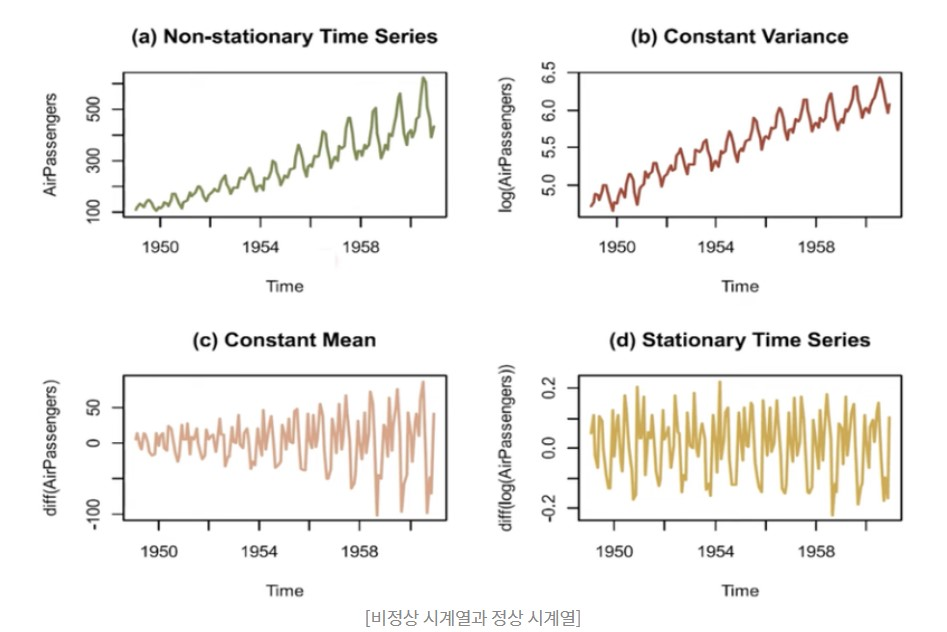

<https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80>

**b. 모형 판별 및 적합**

: ARIMA 모형의 모수(parameter)를 결정하기 위해 크게 두 가지 방법이 존재한다. ACF, PACF 등의 지표를 이용해 적합하는 방법과 AIC 기반으로 자동 선택을 진행하는 방법이다.

ACF, PACF를 이용하는 방법은 AR, MA를 지정한 뒤에 ACF, PACF plot을 그려서 파악할 수 있다.

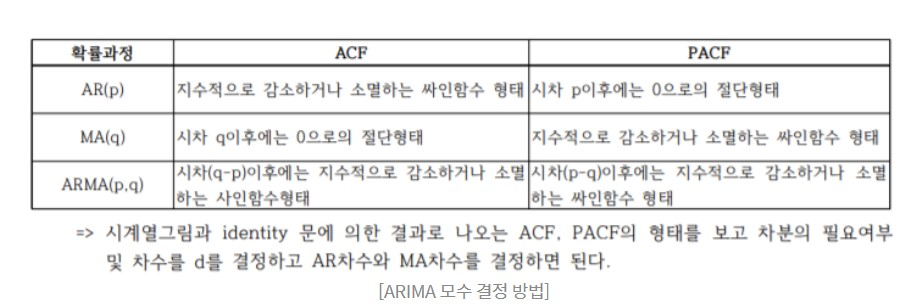

<https://hwao-story.tistory.com/13>

ARIMA 모형에서는 ACF, PACF를 이용하고, SARIMA 모형에서는 **auto_arima()**를 이용해 자동으로 모형을 결정한다.

**d. 모형 점검**

: 모형의 잔차나 예측 결과를 확인해 특별히 이상이 있는지 확인해야 한다. 잔차의 경우 자기상관이 남아있으면 모형이 적절치 않았을 수 있다는 것을 의미한다. 예측 결과가 특별히 예상되는 범위를 벗어나는지, 혹은 도메인 지식과 어긋나는 패턴을 보이지 않는지도 확인해야 한다.

### 2. ARIMA 모형을 활용한 차량 수요 예측

: ARIMA 모형 결정 순서는 다음과 같다.
- 계절성/정상섬 점검 -> 적절한 차분/로그 변환 실시 -> 모형 판별 및 적합 -> 모형 점검

**계절성/정상성 점검**

- 시계열도(Time series plot)

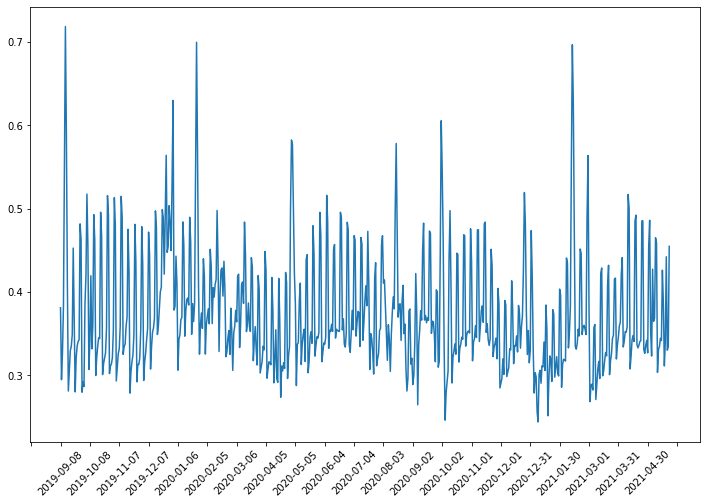

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.plot(df_op_ts['op_rate_0d_all_cars'])
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=30.0)
ax.xaxis.set_major_locator(loc)
plt.show()

: **계절성을 제외하면 자료의 분포가 크게 변화하지 않는다.** 단, 평균이 시간에 따라 조금씩 변화하고 있다.

더 짧은 기간을 그려서 데이터에 주기(cycle)가 있는지 확인해야한다.

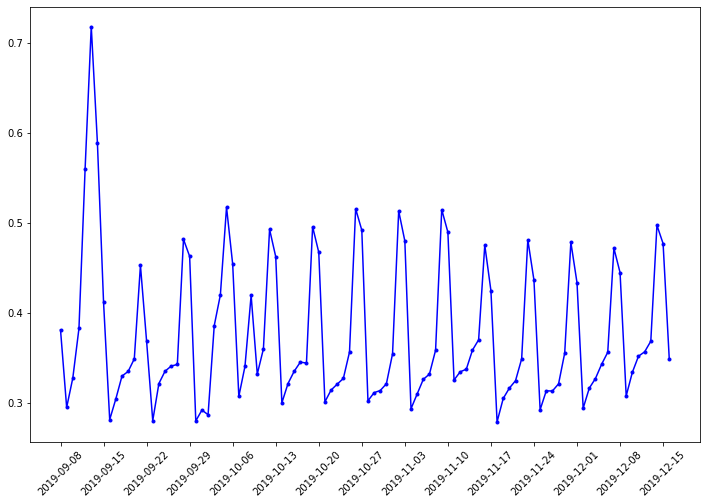

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.plot(df_op_ts['op_rate_0d_all_cars'][0:100], "b.-")
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)
plt.show()

: **데이터의 주기가 7일**임이 명확하게 확인되고 있다. 또한, 유난히 크게 가동률이 상승했던 날짜를 확인할 수 있다. 아마 공휴일인듯 하다.

- STL 분해

: **STL 분해(Seasonal and Trend decomposition using Loess)**을 통해 데이터에 내재된 패턴을 확인.

STL은 시계열에 내제된 Seasonal 성분과 Trend 성분을 쉽게 확인할 수 있는 방법론이다. 비선형 관계를 추정하는 기법인 Loess를 사용하여 어떤 종류의 데이터도 다룰 수 있고, 다른 시계열 분해보다 더 좋은 결과가 나오는 강력한 시계열 분해 기법이다.

시계열은 추세(trend), 계절성(seasonality), 주기(cycle)이라는 3가지 패텉이 존재하는데 추세와 주기를 결합해 하나의 성분으로 여기는 것이 일반적이다. 따라서 시계열은 추세-주성분, 계절성 성분, 나머지(remainder) 성분으로 구성된다. STL 분해는 시계열 성분을 추출하는 시계열 분해 기법 중 하나이다.

STL 분해는 다른 시계열 분해에는 없는 몇 가지 장점이 있다. 첫번째로, 어떤 종류의 계절성도 다룰 수 있다. 두번째는, seasonal window와 trend-cycle window의 매개변수를 조절해 계절성분과 추세-주기 성분을 사용자가 조정할 수 있다. 마지막으로 이상치가 추세-주기와 계절성분에 영향을 주지 않게 만들 수 있다.

단점으로는 STL 분해는 덧셈 분해만 지원하기 때문에 곱셈 분해를 해야 한다면 로그를 취해 분해를 하고 성분을 원래도로 되돌려야 한다는 점이 있다.

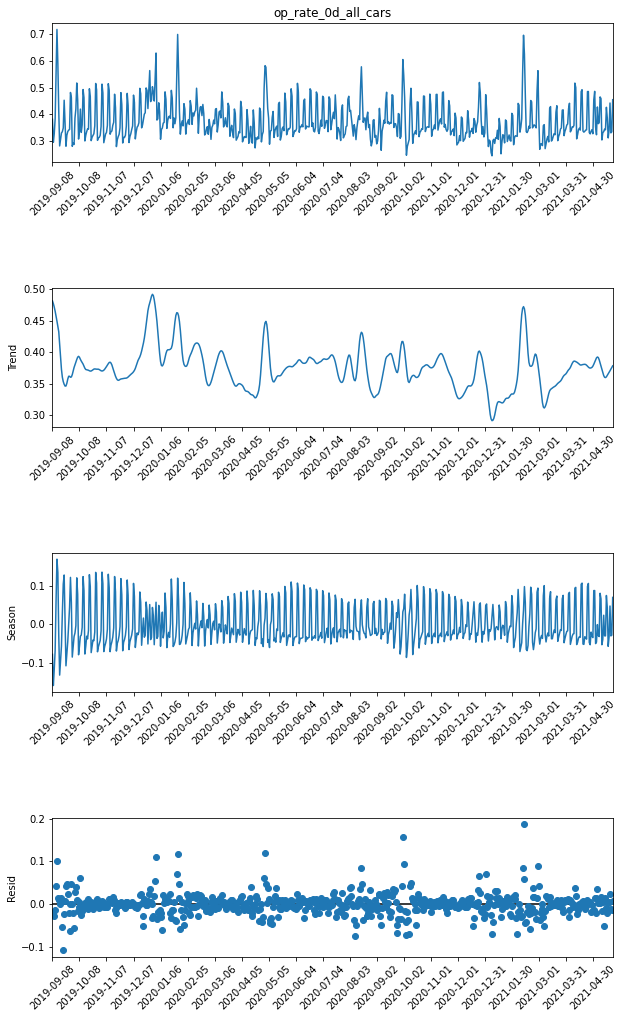

target_dates
2019-09-13    0.100568
2020-01-01    0.110451
2020-01-25    0.117945
2020-05-01    0.120080
2020-10-01    0.156595
2021-02-12    0.187517
Name: resid, dtype: float64


In [7]:
time_series_op_rate = df_op_ts['op_rate_0d_all_cars'] # Create univariate time series
STL_decomposed = STL(time_series_op_rate, seasonal=7, period=7).fit()
fig = STL_decomposed.plot()
fig.set_size_inches(10, 16)

for ax in fig.axes:
    loc = plticker.MultipleLocator(base=30.0)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()
print(STL_decomposed.resid[STL_decomposed.resid>0.1]) # 가설 검증

- STL 분해로 알 수 있는 사실은 다음과 같다.
    - Trend로부터 연중 패턴을 어느 정도 확인할 수 있다. 2019년 9월 초에 가동률이 크게 상승했으며, 그 이후에는 전반적으로 큰 수준의 변화 없이 일정하다는 것을 알 수 있다.
    - Residual을 보면 이상치가 생기는 날짜가 일부 존재하는 모습이 보인다. 그 이유로 '공휴일에 사람들의 수요가 많아 평소에 비해 높은 가동률을 가질 것이다'라는 가설을 세울 수 있다. 실제로 수요가 trend, seasonal 성분에 비해 큰 날짜를 확인해봤을 때 공휴일임을 알 수 있다. 구정, 추석 등 명절 때의 가동률이 특히 높은 것을 예상해 볼 수 있다.

STL 분해를 통해 **Holiday Effect**를 확인할 수 있었다. 이 수치들을 이상치로 취급해 적절히 다른 값으로 대체한 뒤 따로 모델링하는 것이 더 적합하다고 판단할 수 있다. 이상치 처리 방법은 다양한 방식이 있지만 이 프로젝트에서는 **선형 보간법**을 적용하여 처리할 예정이다.

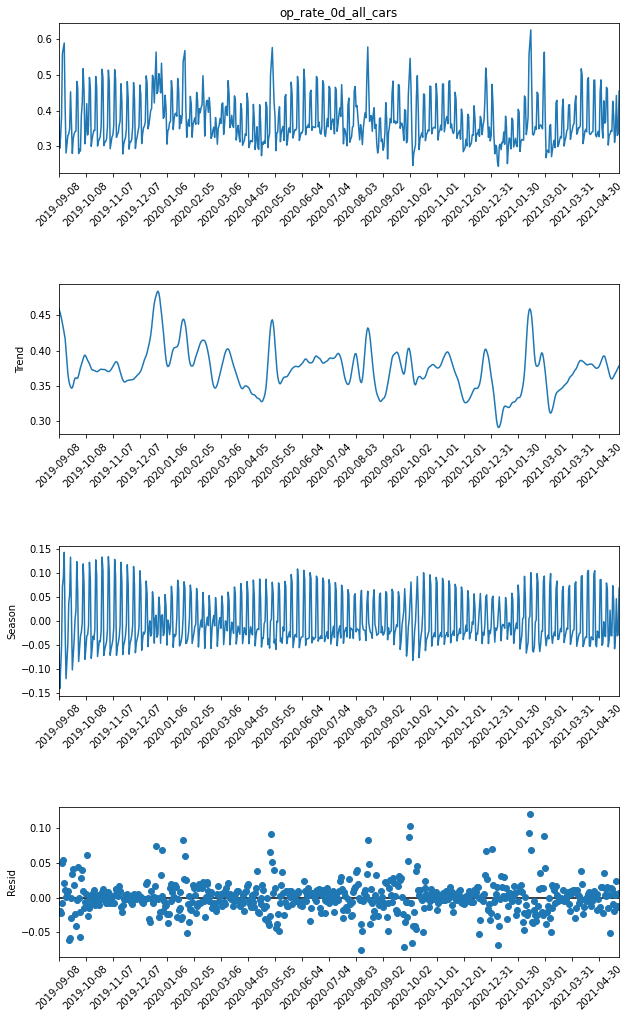

target_dates
2020-10-02    0.103744
2021-02-12    0.121464
Name: resid, dtype: float64


In [8]:
time_series_op_rate_replace = time_series_op_rate.copy()
time_series_op_rate_replace[STL_decomposed.resid>0.1] = np.NaN
time_series_op_rate_replace = time_series_op_rate_replace.interpolate(method='linear') # Linear interpolation

# Outlier를 처리한 뒤의 STL Deocomposition
STL_decomposed_replace = STL(time_series_op_rate_replace, seasonal=7, period=7).fit()
fig = STL_decomposed_replace.plot()
fig.set_size_inches(10,16)

for ax in fig.axes:
    loc = plticker.MultipleLocator(base=30.0)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()
print(STL_decomposed_replace.resid[STL_decomposed_replace.resid>0.1])

: 이상치를 처리한 후에 STL 분해를 해보니 Residual의 분포가 비교적 안정화된 것을 확인할 수 있다.(y축 범위 감소)

- ACF, PACF

**ACF**(자기상관함수, Autocorrelation Function)는 다양한 시차 k에 대한 자기상관값을 의미한다. 즉 yt와 yt+k가 얼마나 관계가 있는지를 측정하는 것이다.

$$ ACF(k) = \frac{cov(y_t,y_{t+k})}{var(y_t)} = \frac{\sum_{t=1}^{N-k}(y_t-\bar{y})(y_{t+k}-\bar{y})}{\sum_{t=1}^{N}(y_t - \bar{y})^2} $$

위 식에서 분모인 분산 var(yt)는 N개의 관측값을, 분자인 공분산 cov(yt, yt+k)는 N-k개의 관측값을 계산한다. ACF plot에서는 유의미한 상관과 유의미하지 않은 상관을 확인할 수 있는데, 점선(유의 한계) 위쪽이 유의미한 값이고, 해당 시차에 대한 상관이 0이 아니라는 것을 의미한다.

**PACF**(편자기상관함수, Partial Autocorrelation Function)는 시점 t와 t-k 사이에 존재하는 t-1, t-2, ..., t-k+1의 영향을 제외하고 구한 자기상관값이다. ACF를 사용해 모든 시계열 데이터를 분석하기에는 한계가 있기 때문에 PACF를 사용한 추가적인 분석이 필요하다. 

$$ PACF(k) = Corr(e_t,e_{t-k}) $$
$$ e_t = Y_t - (\beta_1Y_{t-1} + ... + \beta_1Y_{t-(k-1)}) $$

et는 yt-k를 제외하고 yt-1에서 yt-(k-1)로 설명될 부분을 제거한 것이기 때문에 PACF는 온전히 yt와 yt-k의 관계만 볼 수 있다. PACF plot에서도 점선(유의 한계) 위쪽이 유의미한 값이다.

**ACF나 PACF가 특정한 주기로 크거나 작은 값을 가진다면 계절성을 의심**할 수 있다. ACF, PACF plot을 그려서 데이터에 특정 주기가 있는지 확인해볼 예정이다.

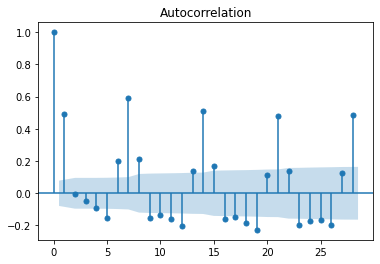

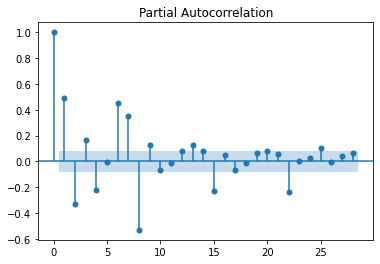

In [9]:
# ACF, PACF plot
plot_acf(time_series_op_rate_replace)
plot_pacf(time_series_op_rate_replace)
plt.show()

: ACF, PACF plot에서 **주기 7의 강한 계절성**을 관측할 수 있다. **lag = 7**로 차분을 실시하고 다시 ACF와 PACF를 확인.

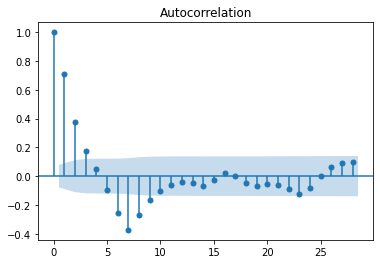

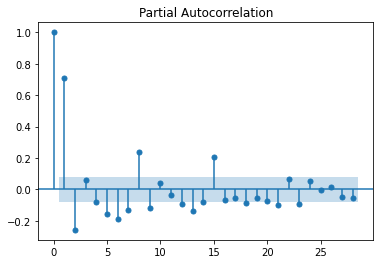

In [10]:
# 차분
time_series_op_rate_diff = time_series_op_rate_replace.diff(7).dropna()
plot_acf(time_series_op_rate_diff)
plot_pacf(time_series_op_rate_diff)
plt.show()

: 계절 차분을 한 이후에도 계절성이 남아있지만, 처음에 비해선 일부 제거된 모습을 보인다.

- **ADF 검정(Augmented Dickey-Fuller Test)**

: 시계열 데이터가 정상적(stationary)인지를 판단하기 위해서 **ADF 검정(Augmented Dickey-Fuller Test)**을 할 수 있다.

ADF 검정은 정상성을 알아보기 위한 단위근 검정 방법이다. 참고로 단위근(unit root)이란 x=1, y=1인 해로, 시계열 자료에서 예측할 수 없는 결과를 가져올 수 있다.

검정에는 자료에 단위근이 존재한다는 귀무가설(Null Hyperthesis, H0: a=1)과 자료에 단위근이 존재하지 않아 시계열 자료가 정상성을 만족한다는 대립가설(Alternative Hypothesis H1: a !=1), 이렇게 2가지 가설을 사용하고, 검정을 통해 귀무가설을 기각하면 정상성을 띤다고 볼 수 있다.

조금 더 자세히 보자면, ADF 검정은 1979년 David Dickey와 Wayne Fuller에 의해 개발된 DF 검정을 일반화한 검정이다. Dickey-Fuller 단위근 검정은 단위근이 존재한다는 귀무가설을 통계적으로 검정하는 방법이다.

$$ y_t = c + \beta_t + \alpha y_{t-1} + \phi\nabla y_{t-1} + e_t $$

위의 식에서 c는 시계열 데이터의 레벨, b(beta)는 시계열 데이터의 추세항이다. 각 파라미터를 regression으로 추정해 a(alpha)가 단위근을 가질 확율을 검정한다. a(alpha)=1이면 단위근을 가지는 것이기 때문에 정상성을 띠지 않는다고 판단한다.

ADF 검정은 DF 검정에 **p log**의 차분을 추가해 검정 능력을 더 강화시켰다.

.

$$ y_t = c + \beta_t + \alpha y_{t-1} + \phi\nabla y_{t-1}+ ... + \phi_p\nabla y_{t-p} + e_t $$


DF 검정의 식에서 **p lag**의 차분만큼 항이 추가된 것을 알 수 있다. t-p시점까지의 차분 경향성을 파악할 수 있어서 주기를 가진 데이터의 정상성 여부를 판단할 수 있다.

ADF 검정의 귀무가설은 DF검정과 귀무가설이 같으므로 **검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 정상적**인 시계열 데이터라고 볼 수 있다.

p-value of ADF test (diff 7): 1.5377815978720525e-12


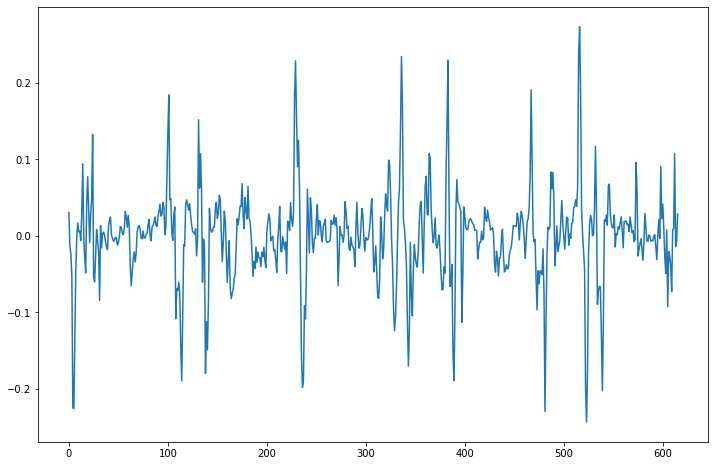

In [11]:
p_value = adfuller(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars)[1]
print(f'p-value of ADF test (diff 7): {p_value}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars);

plt.show()

: ADF 검정 결과, 단위근이 있다는 귀무가설이 유의수준 0.05에서 기각된다. 이는 **시계열이 정상성을 가지고 있다**는 증거이기 때문에 추가적인 차분이나 로그 변환을 진행하지 않아도 된다는 것을 의미한다.

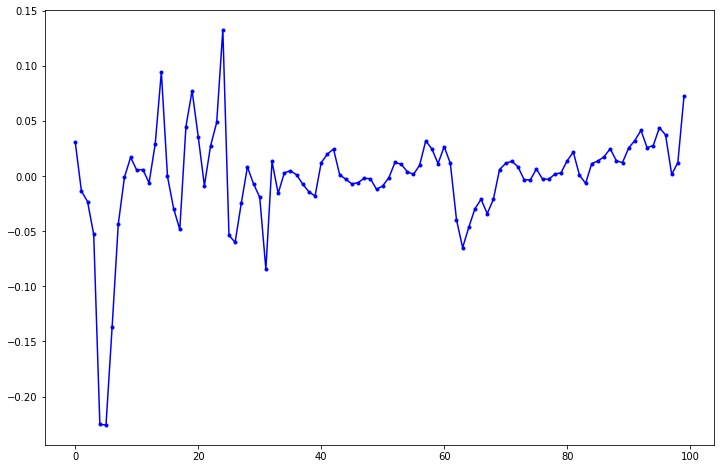

In [12]:
# 더 짧은 기간을 그려 계절성이 제거되었는지 확인
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars[0:100], "b.-")

plt.show()

: 계절 차분 이후 계절성이 제거된 모습이 확인된다.

**모형 적합과 검증**

: ARIMA 모형 적합. 먼저 train data와 test data로 2021년 4월 1일을 기준으로 분리한다. 계절차분을 1번 해주엇기 때문에 d=1이다. ACF, PACF plot을 참고로 하여 모수 p=3, q=1를 가지는 ARIMA 모형을 적합시킨다.

In [13]:
# Split Train/Test data
op_rate_train = time_series_op_rate_diff[time_series_op_rate_diff.index<'2021-04-01']
op_rate_test = time_series_op_rate_diff[time_series_op_rate_diff.index>='2021-04-01']

model = ARIMA(op_rate_train, order=(3,1,1))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                               ARIMA Model Results                               
Dep. Variable:     D.op_rate_0d_all_cars   No. Observations:                  563
Model:                    ARIMA(3, 1, 1)   Log Likelihood                1009.256
Method:                          css-mle   S.D. of innovations              0.040
Date:                   Thu, 17 Mar 2022   AIC                          -2006.513
Time:                           15:34:13   BIC                          -1980.513
Sample:                       09-16-2019   HQIC                         -1996.363
                            - 03-31-2021                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         6.65e-06   3.17e-05      0.210      0.834   -5.54e-05    6.87e-05
ar.L1.D.op_rate_0d_all_cars     0.9612      0.042     22

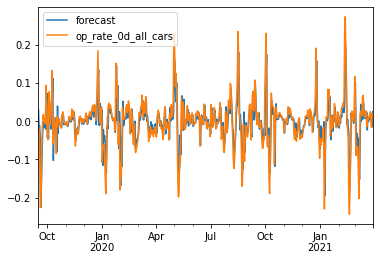

In [14]:
# train data에 대해 ARIMA 모형이 잘 fit하는지 시각화
fitted_m.plot_predict()
plt.show()

Test RMSE: 0.03458806035457616



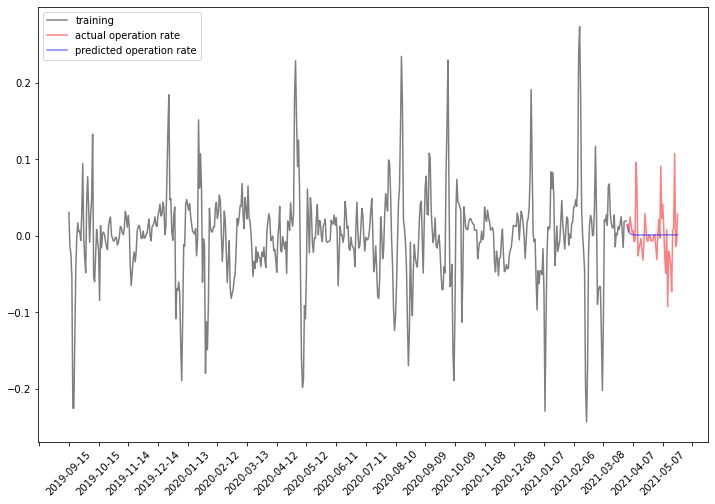

In [15]:
# forecast()를 이용해 테스트 구간의 데이터를 예측해 하고, RMSE 확인
fc, se, conf = fitted_m.forecast(len(op_rate_test), alpha=0.05) # 95% conf

arima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(op_rate_test, fc))
print(f'Test RMSE: {arima_rmse}\n')

# Make as pandas series
fc_series = pd.Series(fc, index=op_rate_test.index) # 예측결과

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(op_rate_train, alpha=0.5, color='black', label='training')
plt.plot(op_rate_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(fc_series, alpha=0.5, color='blue', label='predicted operation rate')
plt.legend()

plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=30.0)
ax.xaxis.set_major_locator(loc)

plt.show()

: ARIMA 모형을 통해 차량 수요 예측을 해 보았지만 이게 잘 되었다고 판단하기엔 아직 이르다.

계절성을 제거하기 전의 데이터를 가지고 SARIMA 모형을 적합한 뒤, 차량 수요 예측을 수행하여 ARIMA 모형의 예측 정확도와 비교해보자.

### 3. SARIMA 모형을 활용한 차량 수요 예측

: ARIMA 모형을 적합시키기 위해 계절성과 정상성을 점검하고, 차분과 로그 변환을 했기 때문에 모형 판별과 적합을 한 뒤 모형이 적절했는지 점검하는 과정으로 진행할 예정이다. ARIMA 모형과는 달리 SARIMA 모형에서는 **auto_arima()**를 사용하여 AIC를 최소로 하는 모델을 자동을 찾을 예정이다.

**SARIMA 모형**

: **SARIMA**(Seasonal Autoregressive Integrated Moving Average) 모형은 **ARIMA 모형(p,d,q)에 계절적 주기 S(seasonal)를 기준으로 하는 AR, I, MA를 추가해 예측**하는 모형이다. 일종의 이중적인 ARIMA 모형이다. 계절적 주기가 들어갔기 때문에 계절성 ARIMA 모형이라고 부르기도 한다. 참고로 ARIMA(p,d,q)와 SARIMA(p,d,q)(0,1,0,0)은 동일한 모형이다.

**계절성은 특정 패턴이 주기적**으로 나타난다. 이 주기적인 특성을 AR 모형이나 MA 모형만을 사용해 나타내는 것은 어렵지만, SARIMA 모형을 사용하면 쉽게 다룰 수 있다. SARIMA 모형의 일반적인 모형은 아래와 같다. 표현되는 항의 수가 많아서 후방이동 연산자 B(Backshift Operator)를 활용해서 간단히 표현한다.

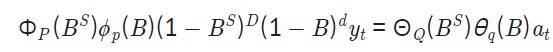

> 후방이동 연산자는 시계열 시차를 다룰 때 유용한 표기법이다. 아래와 같다.
>> $$ B_{yt} = yt-1 $$
>> yt에 작용하는 후방이동 연산자 B는 데이터를 한 시점 뒤로 옮겨준다. 예를 들어 월별 데이터에서 '지난해 같은 달'을 표현하고 싶으면, B^12_yt= yt-12로 표기한다. 또한 d차 차분은(1 - B)^d yt로 표기한다.

위 모형은 SARIMA(p,d,q)(P,D,Q,S)이며, 비계절성 부분 (p,d,q)와 계절성 부분(P,D,Q,S)로 구분할 수 있다. 여기서 p는 비계절성 AR 모형 차수, d는 비계절성 차분 횟수, q는 비계절성 MA 모형 차수, P는 계절성 AR 모형 차수, D는 계절성 차분 횟수, Q는 계절성 MA 모형 차수, S는 주기의 길이를 의미한다. 식에서 보듯 추자적인 계절성 항을 비계절성 항에 곱해준다.

예를 들어, SARIMA(1,0,0)(1,0,0,12)의 경우, 각 달은 한 달 전의 값고 12달 전의 값에 영향을 받는다고 생각할 수 있다. 2021년 9월의 값은 2021년 8월의 값과 2020년 9월의 값의 선형 회귀라고 볼 수 있다.

$$ 2021년9월의값 = (2021년8월의값) * 계수1 + (2020년9월의값) * 계수2 + 오차항 $$

위와 같이 식을 세우고 계수1과 계수2를 추정해 나가면서 AIC등의 적합도와 예측능력을 통해서 모델의 형태를 바꿔나갈 수 있다.

SARIMA 모형을 선택하는 기준은 AIC 등의 적합도와 모형 복잡도 패널티를 종합해 선택하거나 검증 데이터에 대해 모형의 예측 능력을 결정한다.

**모델 판별 및 적합**

: **auto_arima()**를 이용해 **Multiplicative SARIMA 모형**을 적합해볼 예정이다. **auto_arima()**는 AIC를 최소로 하는 모델을 자동으로 찾아주는 역할을 한다. AIC(Akaike Information Criterion)는 주어진 데이터셋에 대한 통계 모델의 상대적인 품질을 평가하는데, AIC 값이 낮을수록 모델의 적합도가 높다는 것을 의미한다.

$$ AIC = -2ln(L) + 2k $$

-2ln(L)은 모형의 적합도이고, L은 Likelihood function이다. k는 모형의 추정된 파라미터의 개수이며, 모형의 패널티를 주기 위해 사용한다. 어떤 모형이 적합도를 높이려고 불필요한 파라미터를 사용할 수도 있는데, 이를 상쇄시키려고 불필요한 파라미터가 증가할수록 2k만큼의 패널티를 주어 모델의 품질을 평가한다.

우선 2021년 4월 1일을 기준으로 train data와 test data를 나눈 후, **auto_arima()**를 사용해 모형을 결정한다. 단, SARIMA 모형을 사용하므로 계절차분을 하지 않은 데이터를 사용한다는 점을 유의해야한다.

In [16]:
model_auto_arima = pm.auto_arima(op_rate_train, seasonal=True, m=7, D=1)

In [17]:
print(model_auto_arima, '\n')
print(model_auto_arima.params(), '\n')
print(model_auto_arima.aic())

 ARIMA(5,0,1)(2,1,0)[7]           

[ 1.38829162 -0.75772537  0.27384359 -0.05186699 -0.09202348 -0.4615594
 -0.80926367 -0.47709509  0.00214064] 

-1816.6536463644084


> 각 파라미터의 의미
>> ARIMA(p,d,q)(P,D,Q,S)[S] = SARIMA(p,d,q)(P,D,Q,S).<br>
>> p는 비계절성 AR 모형 차수, d는 비계절성 차분 횟수, q는 비계절성 MA 모형 차수, P는 계절성 AR 모형 차수, D는 계절성 차분 횟수, Q는 계절성 MA 모형 차수, S는 주기의 길이이다.

**모델 점검**

: 찾은 모델을 점검하는 과정이다.<br>
먼저 예측 결과를 확인해 이상이 있는지 확인한다. 예측 결과가 특별히 예상되는 범위를 벗어나는지, 혹은 도메인 지식과 어긋나는 패턴을 보이지는 않는지 확인해 본다.

Test RMSE: 0.037150831851138794



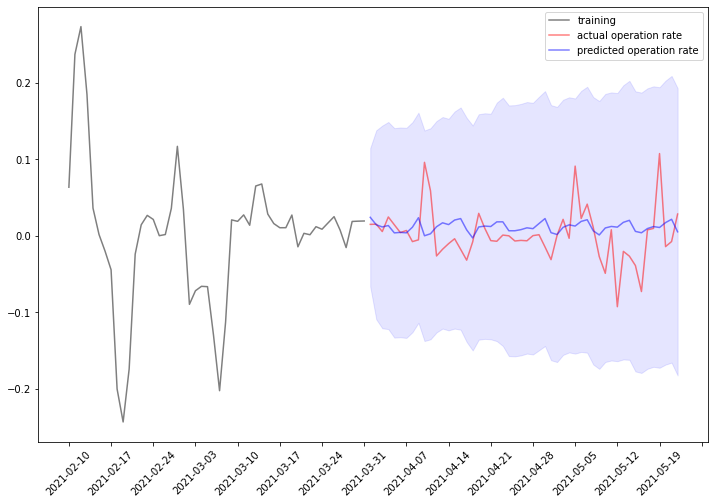

In [18]:
op_rate_pred, conf_int = model_auto_arima.predict(
                                                    n_periods=op_rate_test.shape[0], 
                                                    return_conf_int=True
                                                     )

sarima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(op_rate_test, op_rate_pred))
print(f'Test RMSE: {sarima_rmse}\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)

plt.plot(op_rate_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(op_rate_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(op_rate_test.index.values, op_rate_pred, alpha=0.5, color='blue', label='predicted operation rate')
plt.fill_between(op_rate_test.index.values, conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b') # Confidence Interval
plt.legend()
plt.show()

: 그래프를 통해 보니 실제값과 예측값이 조금 차이가 나 보인다. 이전에 사용했던 ARIMA 모형과 비교해도 예측의 정확도가 낮다.

마지막으로 **plot_diagnostics()**을 이용해 잔차에 대한 검증을 해 본다. 잔차에 자기상관이 남아있다면 모델이 적절치 않았을 수 있다. 왜냐하면 애초에 시계열 분석이 아닌 자기상관성을 파악하기 위한 것이기 때문에 잔차에 아직 독립성이 결여되어 있다면 분석이 될 던 것으로 볼 수 있다.

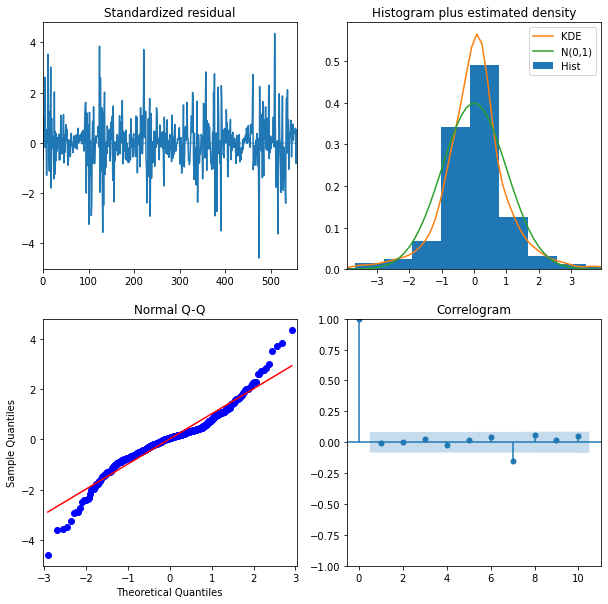

In [19]:
model_auto_arima.plot_diagnostics(figsize=(10,10))
plt.show()

- **Standardized residual**: 일부의 잔차가 이상치로 확인된다.
- **Histogram plus estimated density**: 잔차가 정규분포를 따르지 않는 것으로 보인다. KDE라인이 N(0,1) 라인에 비해 뾰족하다.
- **Normal Q-Q plot**: 잔차의 분포(파란 선)가 양 끝에서 정규분포를 크게 벗어나는 잔차가 많기 때문에 정규성을 띠지 않는다.(잔차의 분포가 정규성을 띠는지, 아닌지가 애매해서 shapiro-wilk test같은 정규성을 검정을 사용해야 한다.)
- **Correlogram(자기상관도)**: 잔차의 자기상관성이 관측되지 않으므로 기존의 계절성을 모델이 효과적으로 해결했다고 볼 수 있다.

### 4. 여러 머신러닝 모델을 활용한 차량 수요 예측

: ARIMA 모델의 예측과 정확도를 비교하기 위해 시계열 자료의 패턴을 이용하지 않은 선형 회귀 분석과 회귀계수 축소법을 사용한다. RMSE를 사용하여 모형의 성능 판다.

> 회귀계수 축소법은 데이터의 과적합 문제를 해결하기 위한 정규화 방법 중 하나이다. 여기서는 Ridge와 Lasso를 사용한다.

**선형 회귀 분석**

: 설명 변수로 존 클릭 수, 날씨, 요일을 넣었으며, **target_dates**를 인덱스로 정함.<br> 데이터셋을 2021년 4월 21일을 기준으로 train 데이터와 test 데이터로 나눈 후, OLS 선형회귀 검정을 수행.

In [20]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)
_x_data = _x_data.sort_values('target_dates')

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)
target = target.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

# 상수항 추가
x_data_train = sm.add_constant(_x_data_train, has_constant='add')
x_data_test = sm.add_constant(_x_data_test, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target_train, x_data_train)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.769
Model:                             OLS   Adj. R-squared:                  0.762
Method:                  Least Squares   F-statistic:                     115.0
Date:                 Thu, 17 Mar 2022   Prob (F-statistic):          3.58e-164
Time:                         15:38:24   Log-Likelihood:                 1111.5
No. Observations:                  571   AIC:                            -2189.
Df Residuals:                      554   BIC:                            -2115.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2046

: R^2=0.769이므로 존 클릭 수, 날씨, 요일이 약 77% 정도 가동률을 설명하고 있다.

In [21]:
# 회귀 모델 평가
ols_pred_test = model_fit.predict(x_data_test)
linreg_rmse = np.sqrt(sklearn.metrics.mean_squared_error(target_test, ols_pred_test))
print(f'Test RMSE: {linreg_rmse}')

Test RMSE: 0.02341016004478106


: 선형 회귀의 평가는 실제값과 회귀 예측값의 차이를 기반으로 한다. RMSE가 0.0234이니 예측값과 실제값의 차이가 크지 않다는 걸 알 수 있다.

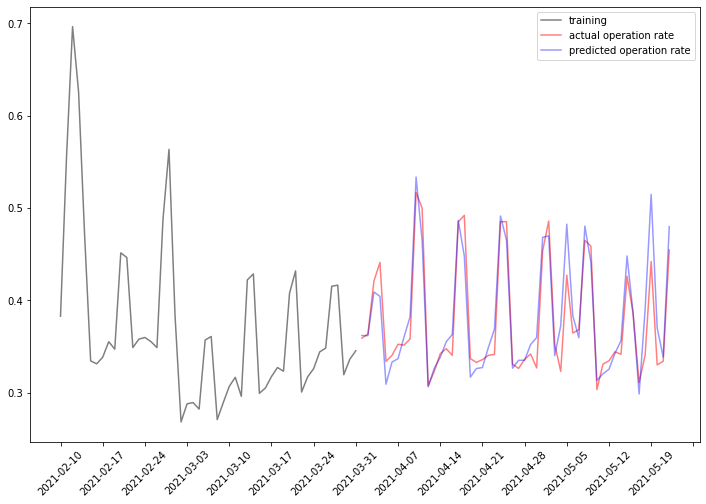

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)

plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, ols_pred_test, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

: 예측값과 실제값이 비슷한 패턴으로 변하는 걸 관측할 수 있다.

**정규화 - 회귀계수 축소법**

: Ridge와 Lasso를 이용한 회귀계수 축소 방법을 사용한다

**회귀계수 축소법**은 회귀계수를 축소하는 항(패널티)를 추가하는 방법이다. 회귀계수를 축소하면 과적합(overfitting) 문제를 해결할 수 있고, 잡음(noise)이 제거되어 모형의 정확도가 개선된다. 중요한 변수만 남기 때문에 모형의 연산 속도도 빨라진다.

회귀계수 축소법에는 축소하는 항이 어떤 것인지에 따라 3가지 방법이 있지만 여기서는 Ridge와 Lasso만 이용할 예정이다. Ridge와 Lasso는 간단하게 L1, L2 정규화를 선형 회귀 모형에 사용한거라 볼 수 있다. 선형 회귀 모형에 L1 정규화를 하면 Lasso, L2 정규화를 하면 Ridge가 된다. (L1, L2 정규화를 모두 적용한 것은 Elastic-Net이다.)

$$ Ridge: minimize \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_jx_{ij})^2 + \lambda\sum_{j=1}^{p}\beta_j^2 $$ 
$$ Lasso: minimize \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_jx_{ij})^2 + \lambda\sum_{j=1}^{p}|\beta_j| $$

: 식에서 람다(하이퍼 파라미터)가 붙은 부분이 L1, L2 정규화 부분이다.
> 사용하는 라이브러리에서는 람다를 알파가 대신한다.

- [회귀계수 축소법-Lasso, Ridge, Elastic-Net 개념](https://todayisbetterthanyesterday.tistory.com/12)

**Ridege**<br>

- 가장 적당한 alpha 값 구하기

In [23]:
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

In [24]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ridge_op_rate_cv = RidgeCV(alphas=alpha_values, cv=5).fit(x_train, y_train.values.ravel())

print(ridge_op_rate_cv.alpha_)

1.0


: 가장 적당한 alpha 값이 1.0으로 나왔다.(alpha 값은 변동될 수 있다.)

In [25]:
# RMSE 값 구하기
ridge_op_rate = Ridge(alpha=1).fit(x_train, y_train)
y_pred_ridge = ridge_op_rate.predict(x_test)
ridge_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_ridge))
print(f'Test RMSE: {ridge_rmse: .5f}')

Test RMSE:  0.02350


: Ridge를 이용했으나 RMSE의 값이 기본 선형회귀 분석과 크게 차이가 나지 않는다.

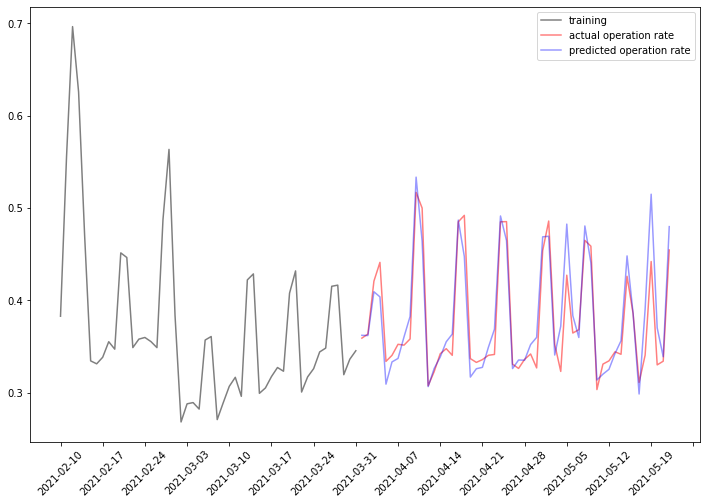

In [26]:
# 시각화
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, y_pred_ridge, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

**Lasso**

In [27]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lasso_op_rate_cv = LassoCV(alphas=alpha_values, cv=5).fit(x_train, y_train)
print(lasso_op_rate_cv.alpha_)

0.0005


In [28]:
lasso_op_rate = Lasso(alpha=0.0005).fit(x_train, y_train)
y_pred_lasso = lasso_op_rate.predict(x_test)
lasso_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_lasso))
print(f'Test RMSE: {lasso_rmse}')

Test RMSE: 0.024277361271249968


: 가장 적절한 alpha 값은 0.0001이고, RMSE는 기본선형회귀분석이나 Ridge보다 조금 높다.

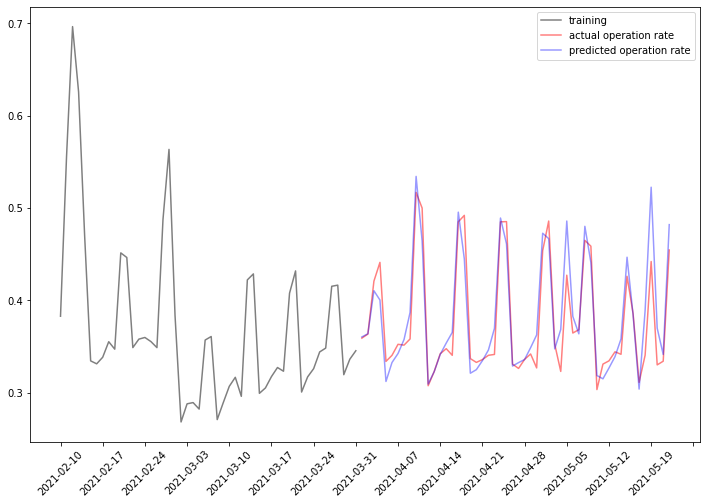

In [29]:
# 시각화
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)


plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, y_pred_lasso, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

: 선형 회귀에서 파생된 모델의 경우, feature의 개수가 그렇게 많지 않았기 때문에 정규화가 큰 효과를 발휘하지 못했음을 확인할 수 있었다.

### 5. 수요 예측 모델의 성능 개선

: 데이터 정제를 통한 성능 개선을 하고자 함.<br>
보통 데이터 정제는 EDA 과정에서 하지만 성능 개선을 위해 데이터 정제를 하는 이유는 데이터 정제를 통한 모델링의 효과를 보기 위해서이다.

데이터 정제 방법에는 여러 가지가 있지만 요기서는 간단히 **이상치(outliers)제거**를 통해 성능을 개선하고자 함.

**이상치 확인**

- 산점도
    - 산점도에서 어떤 패턴이 있는데, 그 패턴에서 벗어나는 값을 이상치라고 할 수 있다. 

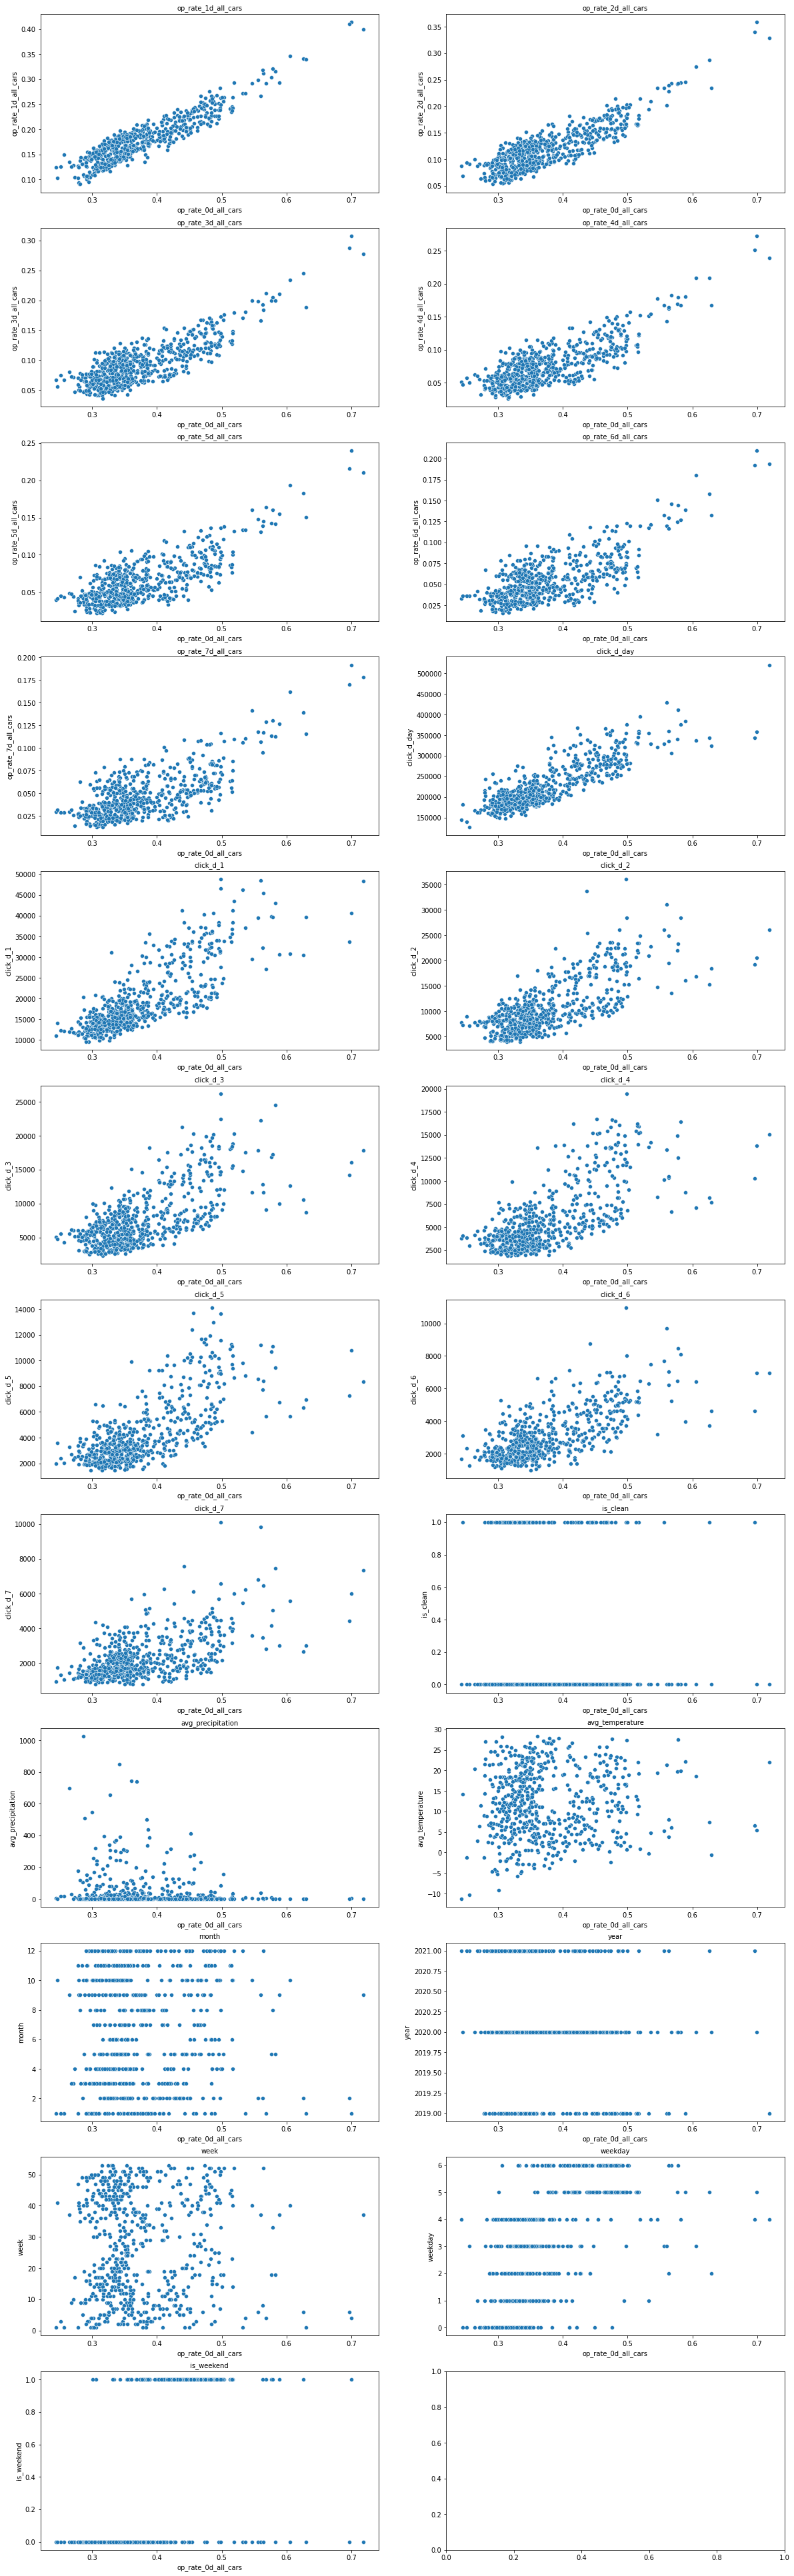

In [31]:
# df_raw 데이터에서 필요 없는 컬럼을 제거하고, 산점도 그리기.
columns = df_raws.columns.tolist()
columns.remove('target_dates')
columns.remove('op_rate_0d_all_cars')
columns.remove('op_rate_0d_major_cars')
columns.remove('op_rate_1d_major_cars')
columns.remove('op_rate_2d_major_cars')
columns.remove('op_rate_3d_major_cars')
columns.remove('op_rate_4d_major_cars')
columns.remove('op_rate_5d_major_cars')
columns.remove('op_rate_6d_major_cars')
columns.remove('op_rate_7d_major_cars')

fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(20, 70))

for i, temp_column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.scatterplot(
        ax=axs[row, col],
        data=df_raws,
        x='op_rate_0d_all_cars',
        y=f'{temp_column}',        
    ).set_title(f'{temp_column}', fontsize=10)
    
plt.show()

**박스플롯**

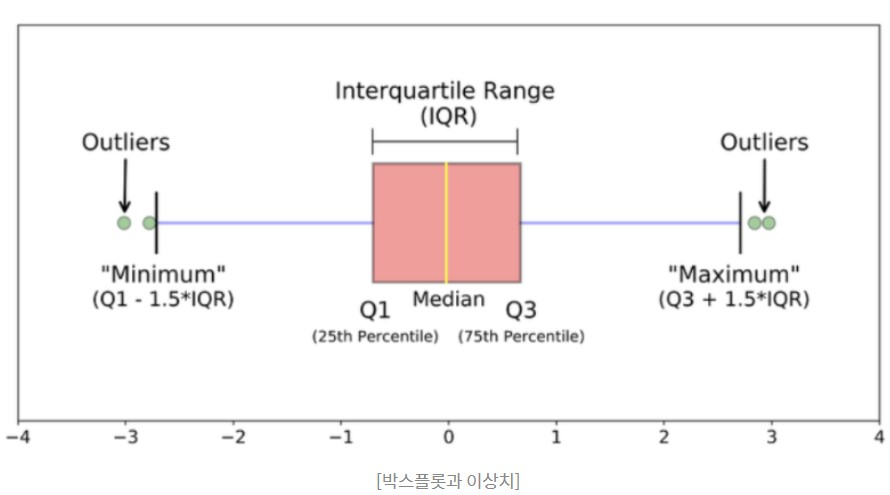

<https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51>

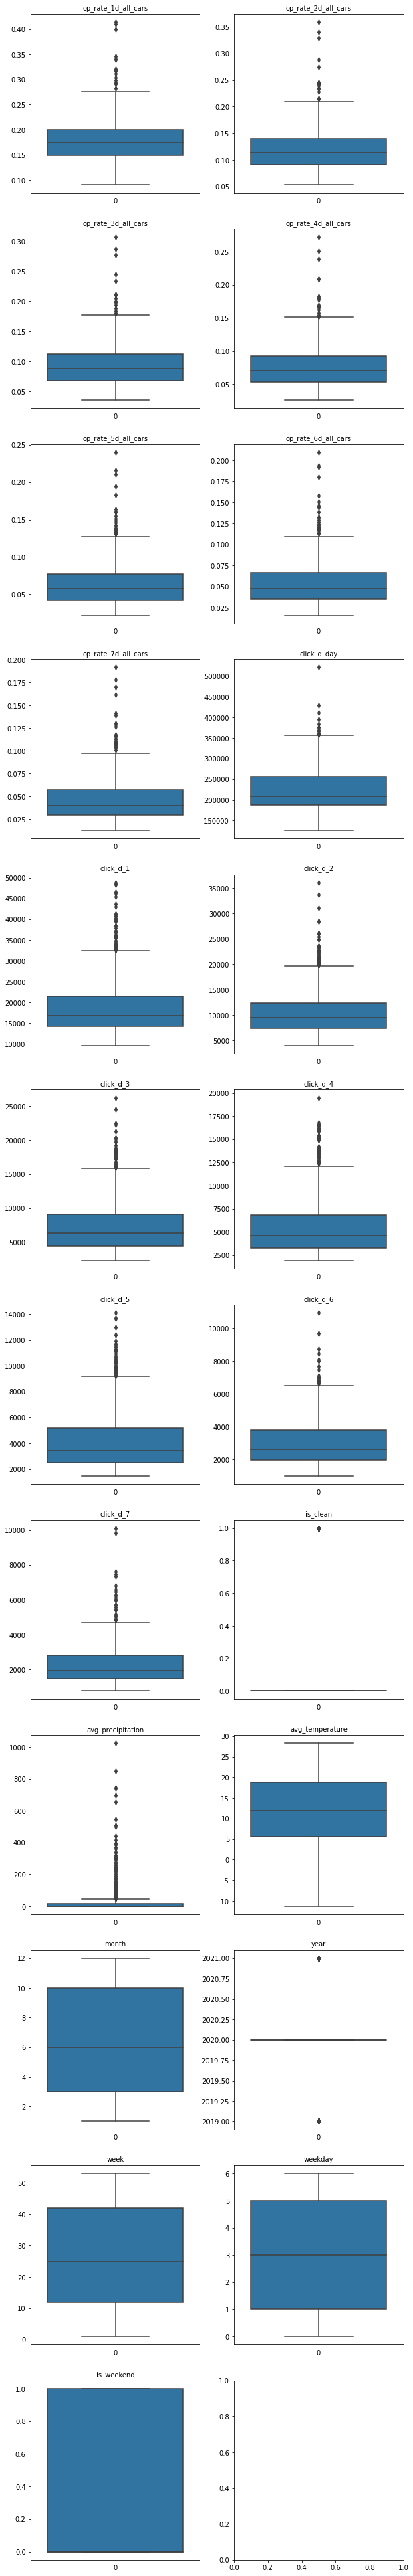

In [32]:
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(10,70))

for i, temp_column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.boxplot(
        ax=axs[row,col],
        data=df_raws[f'{temp_column}']
    ).set_title(f'{temp_column}', fontsize=10)
    
plt.show()

: n일 전 사전 가동률과 n일 전 클릭 수, 평균 강수량 등에서 이상치가 확인된다.

**이상치 제거**

> 이상치를 발견하면 이상치를 무조건 제거하기 보다 이상치가 어떤 값인지 먼저 살펴보아야 한다. 오타나 오류라면 제거해도 되지만 데이터가 작거나 이상치가 중요한 값인 경우에는 평균, 중앙값 등으로 치환하거나 이상치를 따로 분리를 해서 분석하는 방법 등을 생각해 보는 것이 좋다.

이 프로젝트에서는 간단히 이상치를 제거하는 방법을 사용하고자 한다. 이상치 제거 함수(사분위범위수 IQR, Interquartile range이용)를 만들어서 이상치를 제거할 예정이다.

In [33]:
df_clean = df_raws.copy()

# 이상치 제거 함수
def get_outlier(df=None, column=None, weight=1.5):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = df[column][(df[column]<lowest) | (df[column]>highest)].index
    return outlier_idx

In [34]:
outlier_idx_click_d_1 = get_outlier(df=df_clean, column='click_d_1', weight=1.5).tolist()
outlier_idx_click_d_2 = get_outlier(df=df_clean, column='click_d_2', weight=1.5).tolist()
outlier_idx_click_d_3 = get_outlier(df=df_clean, column='click_d_3', weight=1.5).tolist()
outlier_idx_click_d_4 = get_outlier(df=df_clean, column='click_d_4', weight=1.5).tolist()
outlier_idx_click_d_5 = get_outlier(df=df_clean, column='click_d_5', weight=1.5).tolist()
outlier_idx_click_d_6 = get_outlier(df=df_clean, column='click_d_6', weight=1.5).tolist()
outlier_idx_click_d_7 = get_outlier(df=df_clean, column='click_d_7', weight=1.5).tolist()
outlier_idx_avg_precipitation = get_outlier(df=df_clean, column='avg_precipitation', weight=1.5).tolist()

In [35]:
'''설명 변수 컬럼의 이상치의 인덱스를 합치고,
중복된 인덱스를 제거해 이상치가 총 몇 개가 있는지 확인하는 과정'''
# 각 컬럼 outlier index 합치기
outlier_idx = outlier_idx_click_d_1 + outlier_idx_click_d_2 + outlier_idx_click_d_3 + outlier_idx_click_d_4 + outlier_idx_click_d_5 + outlier_idx_click_d_6 + outlier_idx_click_d_7 + outlier_idx_avg_precipitation 

# outlier index 중복 제거
outlier_idx_set = set(outlier_idx)
outlier_idx = list(outlier_idx_set)

len(outlier_idx)

164

이상치 제거 후와 비교하기 위해 제거 전의 정보 확인

In [36]:
df_clean.info()
display(df_clean.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target_dates           623 non-null    object 
 1   op_rate_0d_all_cars    623 non-null    float64
 2   op_rate_1d_all_cars    623 non-null    float64
 3   op_rate_2d_all_cars    623 non-null    float64
 4   op_rate_3d_all_cars    623 non-null    float64
 5   op_rate_4d_all_cars    623 non-null    float64
 6   op_rate_5d_all_cars    623 non-null    float64
 7   op_rate_6d_all_cars    623 non-null    float64
 8   op_rate_7d_all_cars    623 non-null    float64
 9   op_rate_0d_major_cars  623 non-null    float64
 10  op_rate_1d_major_cars  623 non-null    float64
 11  op_rate_2d_major_cars  623 non-null    float64
 12  op_rate_3d_major_cars  623 non-null    float64
 13  op_rate_4d_major_cars  623 non-null    float64
 14  op_rate_5d_major_cars  623 non-null    float64
 15  op_rat

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,...,1650,1318,0,0.0,3.0,11,2019,47,2,False
1,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,...,3808,1956,1,0.0,18.9,9,2020,38,6,True
2,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,...,1693,1326,0,32.1,5.1,11,2019,48,3,False
3,2020-08-31,0.313388,0.142075,0.100732,0.081107,0.063172,0.051917,0.040514,0.038404,0.319582,...,1909,1355,0,22.2,26.0,8,2020,36,0,False
4,2019-10-16,0.334846,0.128528,0.074587,0.050741,0.042454,0.035131,0.026711,0.021401,0.356267,...,1701,1025,1,0.0,13.8,10,2019,42,2,False
5,2020-08-15,0.498408,0.262441,0.202554,0.173028,0.152706,0.136340,0.123184,0.116191,0.492207,...,8021,6579,0,83.7,27.4,8,2020,33,5,True
6,2021-05-20,0.330187,0.178194,0.140476,0.112571,0.093901,0.085936,0.078562,0.070163,0.317130,...,3420,2677,1,0.0,17.7,5,2021,20,3,False
7,2020-09-28,0.309734,0.145407,0.103561,0.081475,0.064365,0.055414,0.046856,0.039182,0.315198,...,3972,2381,1,0.0,18.4,9,2020,40,0,False
8,2020-08-25,0.361382,0.178528,0.112143,0.095936,0.087493,0.079418,0.072070,0.068698,0.368897,...,3781,3302,0,10.3,28.3,8,2020,35,1,False
9,2020-06-20,0.495519,0.238302,0.166035,0.129608,0.102008,0.082998,0.065242,0.056656,0.497479,...,5398,3808,0,1.1,22.5,6,2020,25,5,True


In [37]:
# 이상치 제거 후 데이터 확인
df_clean.drop(outlier_idx, axis=0, inplace=True)

df_clean.info()
display(df_clean.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 0 to 621
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target_dates           459 non-null    object 
 1   op_rate_0d_all_cars    459 non-null    float64
 2   op_rate_1d_all_cars    459 non-null    float64
 3   op_rate_2d_all_cars    459 non-null    float64
 4   op_rate_3d_all_cars    459 non-null    float64
 5   op_rate_4d_all_cars    459 non-null    float64
 6   op_rate_5d_all_cars    459 non-null    float64
 7   op_rate_6d_all_cars    459 non-null    float64
 8   op_rate_7d_all_cars    459 non-null    float64
 9   op_rate_0d_major_cars  459 non-null    float64
 10  op_rate_1d_major_cars  459 non-null    float64
 11  op_rate_2d_major_cars  459 non-null    float64
 12  op_rate_3d_major_cars  459 non-null    float64
 13  op_rate_4d_major_cars  459 non-null    float64
 14  op_rate_5d_major_cars  459 non-null    float64
 15  op_rat

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,...,1650,1318,0,0.0,3.0,11,2019,47,2,False
1,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,...,3808,1956,1,0.0,18.9,9,2020,38,6,True
2,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,...,1693,1326,0,32.1,5.1,11,2019,48,3,False
3,2020-08-31,0.313388,0.142075,0.100732,0.081107,0.063172,0.051917,0.040514,0.038404,0.319582,...,1909,1355,0,22.2,26.0,8,2020,36,0,False
4,2019-10-16,0.334846,0.128528,0.074587,0.050741,0.042454,0.035131,0.026711,0.021401,0.356267,...,1701,1025,1,0.0,13.8,10,2019,42,2,False
6,2021-05-20,0.330187,0.178194,0.140476,0.112571,0.093901,0.085936,0.078562,0.070163,0.317130,...,3420,2677,1,0.0,17.7,5,2021,20,3,False
7,2020-09-28,0.309734,0.145407,0.103561,0.081475,0.064365,0.055414,0.046856,0.039182,0.315198,...,3972,2381,1,0.0,18.4,9,2020,40,0,False
8,2020-08-25,0.361382,0.178528,0.112143,0.095936,0.087493,0.079418,0.072070,0.068698,0.368897,...,3781,3302,0,10.3,28.3,8,2020,35,1,False
10,2021-02-24,0.359877,0.190760,0.123146,0.086862,0.072558,0.061313,0.049403,0.042295,0.351678,...,2518,2145,1,0.0,3.7,2,2021,8,2,False
11,2019-12-02,0.293801,0.103646,0.065057,0.051268,0.039972,0.033637,0.027370,0.023011,0.301985,...,1603,927,0,18.3,3.9,12,2019,49,0,False


**정제된 데이터로 재 모델링**

: 이전과 같이 선형회귀와 Ridge/Lasso를 이용한 계수축소법을 이용.

**a. 선형회귀**

In [38]:
# 설명 변수 테이블 설정
_x_data_clean = df_clean[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday_clean = pd.get_dummies(df_clean['weekday'], prefix='weekday', drop_first=False)

_x_data_clean = pd.concat([_x_data_clean, _x_weekday_clean], axis=1)

_x_data_clean.set_index("target_dates", drop=True, inplace=True)
_x_data_clean = _x_data_clean.sort_values('target_dates')

# 예측 대상 데이터 설정
target_clean = df_clean[['op_rate_0d_all_cars', 'target_dates']]

target_clean.set_index("target_dates", drop=True, inplace=True)
target_clean = target_clean.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train_clean = _x_data_clean[_x_data_clean.index<'2021-04-01']
_x_data_test_clean = _x_data_clean[_x_data_clean.index>='2021-04-01']
target_train_clean = target_clean[target_clean.index<'2021-04-01']
target_test_clean = target_clean[target_clean.index>='2021-04-01']

# 상수항 추가
x_data_train_clean = sm.add_constant(_x_data_train_clean, has_constant='add')
x_data_test_clean = sm.add_constant(_x_data_test_clean, has_constant='add')

# OLS 선형회귀 검정
model_clean = sm.OLS(target_train_clean, x_data_train_clean)
model_clean_fit = model_clean.fit()

# 결과물 출력
print(model_clean_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.732
Model:                             OLS   Adj. R-squared:                  0.722
Method:                  Least Squares   F-statistic:                     69.24
Date:                 Thu, 17 Mar 2022   Prob (F-statistic):          4.56e-105
Time:                         15:44:10   Log-Likelihood:                 880.09
No. Observations:                  422   AIC:                            -1726.
Df Residuals:                      405   BIC:                            -1657.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1946

In [39]:
ols_pred_test_clean = model_clean_fit.predict(x_data_test_clean)
linreg_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(target_test_clean, ols_pred_test_clean))
  
print(f'.    Test RMSE: {linreg_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {linreg_rmse: .5f}')

.    Test RMSE:  0.02036
cf ) Test RMSE( non_clean ):  0.02341


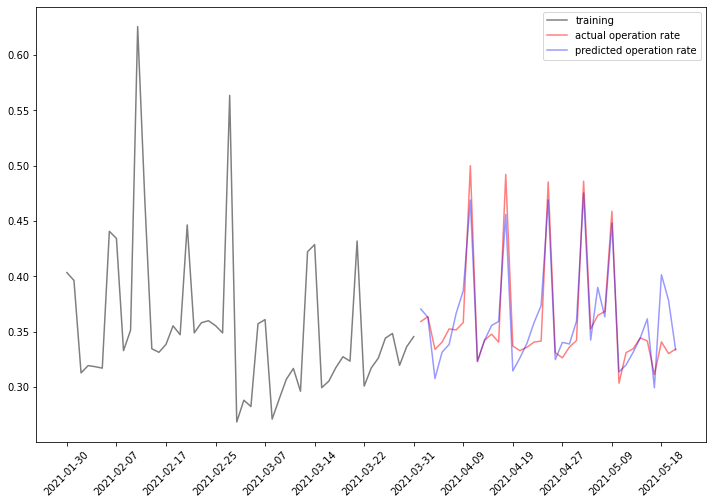

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, ols_pred_test_clean, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

**b. Ridge**

In [41]:
x_train = _x_data_train_clean
x_test = _x_data_test_clean
y_train = target_train_clean
y_test = target_test_clean

alpha_values_clean = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ridge_op_rate_cv_clean = RidgeCV(alphas=alpha_values_clean, cv=5).fit(x_train, y_train.values.ravel())

print(ridge_op_rate_cv_clean.alpha_)

1.0


.    Test RMSE_cleaned:       0.02049
cf ) Test RMSE( non_clean ):  0.02350




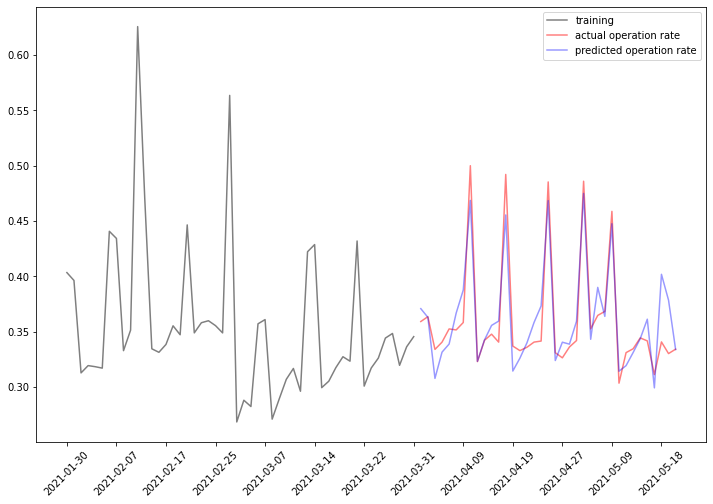

In [42]:
ridge_op_rate = Ridge(alpha=1).fit(x_train, y_train)
y_pred_ridge = ridge_op_rate.predict(x_test)
ridge_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_ridge))
print(f'.    Test RMSE_cleaned:      {ridge_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {ridge_rmse: .5f}\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)


plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, y_pred_ridge, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

**c. Lasso**

In [43]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lasso_op_rate_cv = LassoCV(alphas=alpha_values, cv=5).fit(x_train, y_train.values.ravel())

print(lasso_op_rate_cv.alpha_)

0.0005


     Test RMSE:               0.02047
cf ) Test RMSE( non_clean ):  0.02428




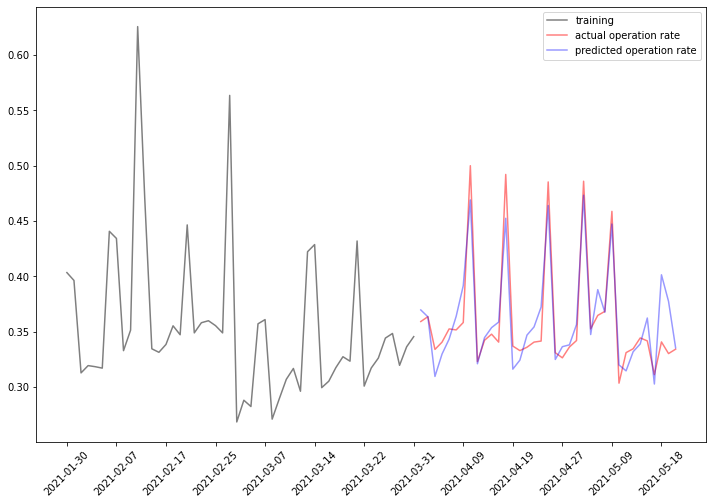

In [44]:
lasso_op_rate = Lasso(alpha=0.0005).fit(x_train, y_train)
y_pred_lasso = lasso_op_rate.predict(x_test)
lasso_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_lasso))
print(f'     Test RMSE:              {lasso_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {lasso_rmse: .5f}\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, y_pred_lasso, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

     Test RMSE:               0.02047
cf ) Test RMSE( non_clean ):  0.02428




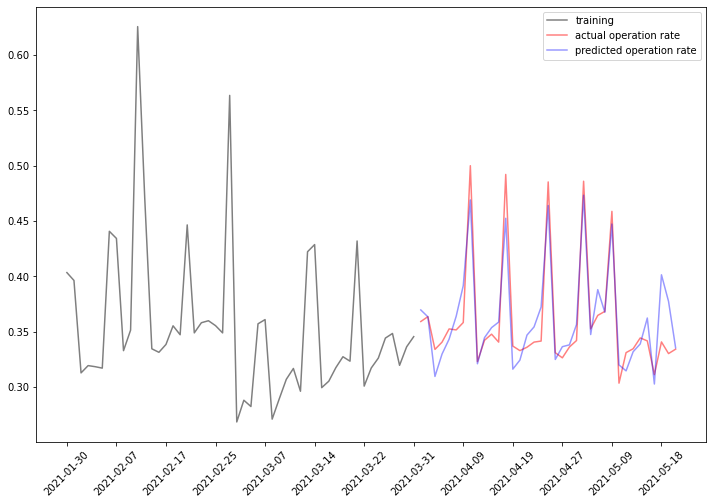

In [45]:
lasso_op_rate = Lasso(alpha=0.0005).fit(x_train, y_train)
y_pred_lasso = lasso_op_rate.predict(x_test)
lasso_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_lasso))
print(f'     Test RMSE:              {lasso_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {lasso_rmse: .5f}\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, y_pred_lasso, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

: 이상치를 제거하고 모델링을 하면 성능(RMSE 등) 개선 효과는 있다. 하지만 지금 다루고 있는 시계열 데이터에서는 빈틈이 생기면 안 되기 때문에 선형 보간법 등으로 해당 이상치를 다른 값으로 대체해 주는 것이 좋다. 위와 같이 이상치를 제거하고 시계열 데이터를 다룬다면 소용이 없다.

### 6. 동적 회귀 모형의 이해

: 시계열 모형에는 시계열의 이전 관측값에서 얻은 정보는 들어가지만, 존 클릭 수, 날씨, 요일 등의 외부 변수들은 들어가지 않는다. 하지만 때로는 과거의 변동을 더 잘 설명할 수 있는 외부 변수가 더 정확하게 예측할 수도 있다. 반대로 회귀 모형은 예측 변수(predictor variable)와 관련된 정보를 포함하지만 시계열을 다루기 어렵다.

'만약 시계열 데이터와 외부 변수를 모두 다룰 수 있다면 더 정확하게 예측할 수 있지 않을까?'라는 아이디어에서 만들어진 것이 **동적 회귀 모형(Regression with ARIMA error/Dynamic Regression Model)**이다. 쉽게 말하면 오차항에 ARIMA 구조를 가정한 모형이다. 오차에 자기상관 구조가 존재하는 경우에 사용할 수 있다.

회귀 모형의 식이 아래와 같다고 가정해보면, yt는 k예측변수 (x1,t, ..., xk,t)의 선형 함수이고, et는 상관관계가 없는 오차항(백색 잡음)이다.
$$ y_t = \beta_0 + \beta_1x_{1,t} + ... + \beta_kx_{k,t} + \epsilon_t $$

동적 회귀 모형은 자기상관을 넣기 위해 회귀 모형에 엡실론_t 대신 에타_t을 넣어주고, 에타_t이 ARIMA 모형을 따른다고 가정하고, 만약 에타_t가 ARIMA(1,1,1) 모형을 따르면 동적 회귀 모형은 아래와 같이 쓸 수 있다.(아래 식의 엡실론_t는 백색잡음 시계열이다.)
$$ y_t = \beta_0 + \beta_1x_{1,t} + ... + \beta_kx_{k,t} + \eta_t $$
$$ (1 - \phi_1\beta)(1 - \beta)\eta_t = (1 + \theta_1\beta)\epsilon_t $$

동적 회귀 모형에는 두 개의 오차항, 즉 회귀 모형에서 온 오차(에타_t)와 ARIMA 모형에서 온 오차(엡실론_t)가 있고, ARIMA 모형 오차만 백색잡음이다.

- [Chapter 9 동적 회귀 모델](https://otexts.com/fppkr/dynamic.html)

**SARIMAX**

: 동적 회귀 모델 사용. **stats.model**의 SARIMAX를 사용.<br>
SARIMAX에서 X는 외부 변수인 eXogeneous를 의미. 즉, SARIMAX는 ARIMA 모형과 외부 변수를 합한 단어이고, 동적 회귀 모형을 생성한다.


- SARIMAX의 주요 파라미터
    - endog: 관측된 시계열 데이터 (endogeneous)
    - exog: 시계열 데이터에 영향을 미치는 외부 변수 데이터 (exogeneous)
    - order: ARIMA의 (p,d,q), default는 (1,0,0)
    - seasonal_order: 계절성 부분인 (P,D,Q,S)

동적 회귀 모형을 모델링을 하기 위해서는 하이퍼파라미터 p,d,q,P,D,Q를 설정해 주어야 한다. 주기(S)의 경우에는 분기별 데이터일 경우에는 4, 월별 데이터의 경우에는 12로 설정해준다. 이번 프로젝트에서 예측하고자 하는 데이터의 주기는 7이므로 S=7로 설정한다.

그 후 가장 낮은 AIC 값을 가지는 파라미터 조합을 선택하는데, 일반적으로 Grid search를 한다.

- [SARIMAX 공식 홈페이지](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

- 차량 수요 예측을 하기 전에 다른 데이터를 사용한 간단한 동적 회귀 모형 예제 파악

In [46]:
# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

data.head()

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976


- 데이터 변수 정의
    - m2(광의통화): M1과 만기 2년 미만 정기 예/적금과 같이 약간의 이자만 포기하면 현금화할 수 있는 금융 상품을 포함한다. MMF(머니마켓펀드), CD(양도성예금증서), CMA(종합자산관리계좌) 등의 시장형 금융상품, 금전신탁, 수익증권 등의 실적 배당형 금융상품, 금융, 종금사 발행어음 등도 포함한다.
    - m1(협의통화): 지폐, 동전, 요구불예금을 포함한 현금통화로, 언제든지 현금으로 전환될 수 있는 통화.
    - consump:개인 소비를 의미하며 단위는 '$'이며, UAB 국민소득계정(NIPA)을 이용해 산출한 수치
    - pc92: 개인 소비를 의미

In [51]:
display(data.info())
print('\n')
display(data.isnull().sum())
print('\n')
display(data[data['m1'].isnull()])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 1946-01-01 to 1998-07-01
Freq: QS-OCT
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   m2       159 non-null    float32       
 1   time     211 non-null    datetime64[ns]
 2   m1       159 non-null    float32       
 3   consump  211 non-null    float32       
 4   pc92     207 non-null    float32       
dtypes: datetime64[ns](1), float32(4)
memory usage: 6.6 KB


None

m2         52
time        0
m1         52
consump     0
pc92        4
dtype: int64

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976
1947-04-01,NaN,1947-04-01,NaN,160.500000,928.500000
1947-07-01,NaN,1947-07-01,NaN,164.100006,931.900024
1947-10-01,NaN,1947-10-01,NaN,168.199997,932.099976
1948-01-01,NaN,1948-01-01,NaN,170.899994,936.200012


: 결측치는 m2, m1에 52개씩 존재하고, 1959년 이전의 데이터가 존재하지 않는다. 그러므로 1959년 이후의 데이터만 사용.

이 데이터로는 간단하게 동적 회귀 모형을 사용해 보는 것이므로 EDA나 데이터 전처리는 생략하고 진행. 내부 변수이자 시계열 부분으로는 'consump', 외부 변수로는 'm2'를 설정. 파라미터인 orders는 임의로 설정.

In [52]:
# Variables
endog = data.loc['1959':, 'consump']
exog = sm.add_constant(data.loc['1959':, 'm2'])
nobs = endog.shape[0]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                  159
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -718.508
Date:                Thu, 17 Mar 2022   AIC                           1447.015
Time:                        16:14:15   BIC                           1462.360
Sample:                    01-01-1959   HQIC                          1453.247
                         - 07-01-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -235.0780   1.28e+04     -0.018      0.985   -2.54e+04    2.49e+04
m2             1.0000      0.091     11.022      0.000       0.822       1.178
ar.L1          0.9997      0.001    674.846      0.0

: 모형의 적합성은 다음과 같이 판단할 수 있다.

- Ljung-Box(L1)
    - 시계열의 모형이 올바르게 적합되었는지 평가하는 시계열 모형 적합도 척도 중 하나이다. 귀무가설은 '잔차가 white noise를 따른다'로 설정하고, p-value가 낮으면 시간대별 잔차가 상관(correlated)되어 있는 것으로 판단할 수 있다.
- Jarque-Bera
    - 귀무가설을 '잔차가 normal distribution을 따른다'라고 가정하며, p-value가 낮으면 귀무가설을 기각.
- Heteroskedasticity
    - 각 시간대 별 잔차의 분산이 일정한지 보는 테스트이며, 귀무가설을 '잔차의 분산이 일정하다'라고 가정하며 p-value가 낮으면 귀무가설을 기각한다.
    
Ljung-Box(L1)의 값은 작고, Jarque-Bera와 Heteroskedasticity의 값은 크므로 좋은 모형은 아니다.

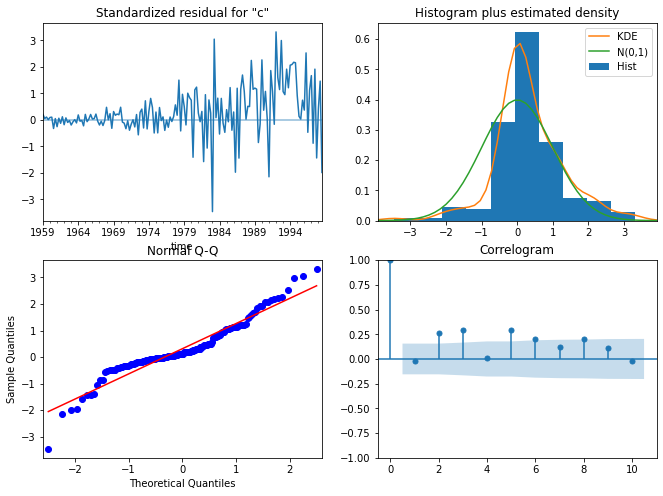

In [53]:
# plot_diagnostic()을 이용한 잔차 확인
fit_res.plot_diagnostics(figsize=(11, 8))
plt.show()

: 잔차의 분포를 나타낸 그래프도 위의 모형이 좋은 모형이 아니라는 것을 보여 준다.
히스토그램과 Q-Q 플롯을 보니 잔차가 정규성을 띠지 않는 것처럼 보인다. Correlogram에서도 잔차가 자기상관되는 것으로 보인다.

하지만 파라미터를 조정하면 더 좋은 결과를 얻을 수 있을듯 하다. 그래서 보통은 Grid search를 통해 최적의 파라미터를 찾는다.

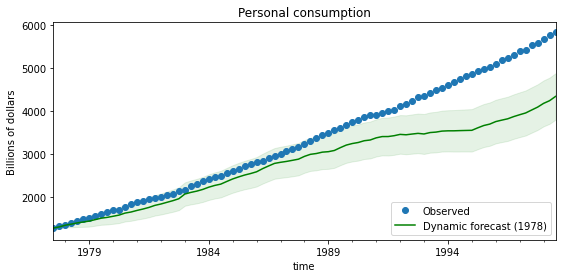

In [56]:
# 모형을 통한 예측 및 시각화를 통한 모형의 예측 점검
pred = fit_res.get_prediction(dynamic='1978-01-01')
pred_ci = pred.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions

pred.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = pred_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')


: 시각화한 결과 시간이 흐를수록 예측을 잘 하고 있지 못함을 알 수 있다. 그 이유는 파라미터를 임의로 설정한 부분일 수도 있다.